# 合併加法器與減法器
# 本程式為建構一深度學習模型，可同時處理加法與減法，輸入一段三位數 +或- 三位數之算式，計算及答案。 並比較不同神經元個數、Epoch次數之影響。

## 匯入所需library，主要使用keras建立神經網路

In [36]:
import numpy as np
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

## 自行生成加法和減法算式資料

In [4]:
DIGITS = 3
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+- '

questions = []
expected = []

print('Generating data...')

for a in range(0, 1000):
    for b in range(0, 1000):
        # 不論 a,b誰大，都要產生加法運算資料
        q = '{}+{}'.format(str(a), str(b))    # 將 +號 插進兩數字中，產生數學式的字串
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a + b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        questions.append(query)
        expected.append(ans)
        if a > b:   # 若a大於b，才產生減法運算資料
            q = '{}-{}'.format(str(a), str(b))    # 將 -號 插進兩數字中，產生數學式的字串
            query = q + ' ' * (MAXLEN - len(q))
            ans = str(a - b)
            ans += ' ' * (DIGITS + 1 - len(ans))
            questions.append(query)
            expected.append(ans)
        
print('Finish!')

Generating data...
Finish!


In [47]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))      # char to integer
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))      # integer to char
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)
      
ctable = CharacterTable(chars)

## 將產生好的資料化為 One-Hot Encoding

In [6]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.int)  
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.int)

# One-Hot encoding
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)
    
print('Finish!')

Vectorization...
Finish!


## 拆分訓練、驗證、測試資料集

In [8]:
# 拆分訓練、驗證、測試資料集
test_ratio = 0.2
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_ratio, random_state=0)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=test_ratio, random_state=0)

print('Training Data:')
print(train_x.shape)
print(train_y.shape)

print('Validation Data:')
print(valid_x.shape)
print(valid_y.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(959680, 7, 13)
(959680, 4, 13)
Validation Data:
(239920, 7, 13)
(239920, 4, 13)
Testing Data:
(299900, 7, 13)
(299900, 4, 13)


In [9]:
ctrain_x = train_x.reshape(train_x.shape[0], -1, 1).squeeze(axis=2)
ctest_x = test_x.reshape(test_x.shape[0], -1, 1).squeeze(axis=2)
ctrain_y = train_y.reshape(train_y.shape[0], -1, 1).squeeze(axis=2)
ctest_y = test_y.reshape(test_y.shape[0], -1, 1).squeeze(axis=2)
cvalid_x = valid_x.reshape(valid_x.shape[0], -1, 1).squeeze(axis=2)
cvalid_y = valid_y.reshape(valid_y.shape[0], -1, 1).squeeze(axis=2)

## 固定訓練10個 epochs, 以不同的隱藏層神經元個數訓練，比較 accuracy


In [55]:
acc_list = []
for n_neurons in range(50, 501, 50):
    input1 = Input(shape=(91,))
    w1 = Dense(n_neurons, activation='relu', name='weight1')
    dense1 = w1(input1)
    w2 = Dense(52, activation='softmax', name='weight2')
    output1 = w2(dense1)

    model = Model(inputs=[input1], outputs=[output1])
    model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    h = model.fit(x=[ctrain_x], y=[ctrain_y], validation_data=[cvalid_x, cvalid_y], epochs=10)
    
    # 預測測試集
    predicted = model.predict(ctest_x).reshape(ctest_x.shape[0], 4, 13)
    
    # 將預測結果(one-hot編碼)轉回一般數值
    labels = []
    ans = []
    for i in range(0, len(test_y)):
        labels.append(ctable.decode(test_y[i]))
        ans.append(ctable.decode(predicted[i]))
    # 計算測試資料正確率
    acc = accuracy_score(ans, labels)
    acc_list.append(acc)    

Train on 959680 samples, validate on 239920 samples
Epoch 1/10
959680/959680 [==============================] - 48s 50us/step - loss: 10.7399 - acc: 0.3197 - val_loss: 10.0423 - val_acc: 0.2606
Epoch 2/10
959680/959680 [==============================] - 45s 47us/step - loss: 9.9065 - acc: 0.2637 - val_loss: 9.8095 - val_acc: 0.2718
Epoch 3/10
959680/959680 [==============================] - 45s 47us/step - loss: 9.7503 - acc: 0.2614 - val_loss: 9.7023 - val_acc: 0.2372
Epoch 4/10
959680/959680 [==============================] - 45s 47us/step - loss: 9.6730 - acc: 0.2614 - val_loss: 9.6397 - val_acc: 0.2516
Epoch 5/10
959680/959680 [==============================] - 46s 48us/step - loss: 9.6165 - acc: 0.2625 - val_loss: 9.5892 - val_acc: 0.2767
Epoch 6/10
959680/959680 [==============================] - 45s 47us/step - loss: 9.5764 - acc: 0.2630 - val_loss: 9.5634 - val_acc: 0.2621
Epoch 7/10
959680/959680 [==============================] - 46s 48us/step - loss: 9.5526 - acc: 0.2632 - v

959680/959680 [==============================] - 48s 50us/step - loss: 7.0890 - acc: 0.2509 - val_loss: 7.0705 - val_acc: 0.2206
Epoch 8/10
959680/959680 [==============================] - 48s 50us/step - loss: 7.0577 - acc: 0.2503 - val_loss: 7.0500 - val_acc: 0.3257
Epoch 9/10
959680/959680 [==============================] - 38s 40us/step - loss: 7.0339 - acc: 0.2496 - val_loss: 7.0248 - val_acc: 0.2888
Epoch 10/10
959680/959680 [==============================] - 37s 38us/step - loss: 7.0155 - acc: 0.2506 - val_loss: 7.0080 - val_acc: 0.3377
Train on 959680 samples, validate on 239920 samples
Epoch 1/10
959680/959680 [==============================] - 40s 42us/step - loss: 8.5414 - acc: 0.2444 - val_loss: 7.5580 - val_acc: 0.2326
Epoch 2/10
959680/959680 [==============================] - 39s 40us/step - loss: 7.3718 - acc: 0.2537 - val_loss: 7.2334 - val_acc: 0.2349
Epoch 3/10
959680/959680 [==============================] - 39s 41us/step - loss: 7.1657 - acc: 0.2519 - val_loss: 7.1

## 下圖可發現，隨著神經元個數變多，accuracy持續成長，並逐漸緩慢下來

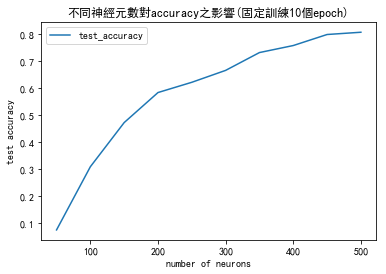

In [56]:
#coding:utf-8
plt.rcParams['font.sans-serif']=['SimHei']   # 設定中文字體
plt.title(u'不同神經元數對accuracy之影響(固定訓練10個epoch)')
plt.xlabel('number of neurons')
plt.ylabel('test accuracy')
plt.plot(np.arange(50, 501, 50), acc_list, label='test_accuracy')
plt.legend()
plt.show()

## 固定神經元個數為300，比較訓練不同 epoch 次數之影響，並畫出訓練過程loss與accuracy之變化

In [62]:
# 固定神經元個數，比較訓練不同 epoch 次數之影響
epoch_size = 200

input1 = Input(shape=(91,))
w1 = Dense(300, activation='relu', name='weight1')
dense1 = w1(input1)
w2 = Dense(52, activation='softmax', name='weight2')
output1 = w2(dense1)

model = Model(inputs=[input1], outputs=[output1])
model.compile(optimizer='adam', loss=['categorical_crossentropy'])

accuracy_list = []
train_loss_list = []
val_loss_list = []

for i in range(1, epoch_size+1):
    print('Epoch {}/{}'.format(i, epoch_size))
    h = model.fit(x=[ctrain_x], y=[ctrain_y], validation_data=[cvalid_x, cvalid_y])
    train_loss_list.append(h.history['loss'][0])
    val_loss_list.append(h.history['val_loss'][0])
    
    # 預測測試集
    predicted = model.predict(cvalid_x).reshape(cvalid_x.shape[0], 4, 13)
    # 將預測結果(one-hot編碼)轉回一般數值
    labels = []
    ans = []
    for i in range(0, len(valid_y)):
      labels.append(ctable.decode(valid_y[i]))
      ans.append(ctable.decode(predicted[i]))

    # 計算正確率
    acc = accuracy_score(ans, labels)
    print('accuracy: ', acc)
    accuracy_list.append(acc)

Epoch 1/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 40s 42us/step - loss: 8.7018 - val_loss: 7.7178
accuracy:  0.470961153717906
Epoch 2/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 72s 75us/step - loss: 7.5092 - val_loss: 7.3656
accuracy:  0.5686312104034679
Epoch 3/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 80s 84us/step - loss: 7.2907 - val_loss: 7.2202
accuracy:  0.6115746915638546
Epoch 4/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 84s 88us/step - loss: 7.1892 - val_loss: 7.1569
accuracy:  0.6299224741580527
Epoch 5/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 86s 90us/step - loss: 7.1210 - val_loss: 7.0942
accuracy:  0.6446773924641

959680/959680 [==============================] - 85s 89us/step - loss: 6.7151 - val_loss: 6.7235
accuracy:  0.7571607202400801
Epoch 42/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 80s 84us/step - loss: 6.7091 - val_loss: 6.7082
accuracy:  0.7607077359119706
Epoch 43/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 85s 88us/step - loss: 6.7015 - val_loss: 6.7047
accuracy:  0.7640713571190397
Epoch 44/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 85s 89us/step - loss: 6.6957 - val_loss: 6.7040
accuracy:  0.7630293431143714
Epoch 45/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 88s 91us/step - loss: 6.6901 - val_loss: 6.7026
accuracy:  0.7614954984994998
Epoch 46/200
Train on 959680 samples, validate on 239920 samples


959680/959680 [==============================] - 79s 82us/step - loss: 6.5949 - val_loss: 6.5986
accuracy:  0.7910470156718906
Epoch 83/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 89s 92us/step - loss: 6.5934 - val_loss: 6.5991
accuracy:  0.7949441480493498
Epoch 84/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 89s 92us/step - loss: 6.5928 - val_loss: 6.5875
accuracy:  0.799274758252751
Epoch 85/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 89s 93us/step - loss: 6.5902 - val_loss: 6.5997
accuracy:  0.7970990330110037
Epoch 86/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 87s 91us/step - loss: 6.5875 - val_loss: 6.5777
accuracy:  0.7952359119706569
Epoch 87/200
Train on 959680 samples, validate on 239920 samples
E

accuracy:  0.8078942980993664
Epoch 123/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 46s 48us/step - loss: 6.5522 - val_loss: 6.5512
accuracy:  0.8081027009003001
Epoch 124/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 43s 45us/step - loss: 6.5517 - val_loss: 6.5569
accuracy:  0.8088237745915305
Epoch 125/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 42s 44us/step - loss: 6.5511 - val_loss: 6.5548
accuracy:  0.80351783927976
Epoch 126/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 45s 47us/step - loss: 6.5512 - val_loss: 6.5558
accuracy:  0.8049683227742581
Epoch 127/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 43s 45us/step - loss: 6.5501 - val_

959680/959680 [==============================] - 37s 39us/step - loss: 6.5342 - val_loss: 6.5421
accuracy:  0.812079026342114
Epoch 164/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 38s 40us/step - loss: 6.5344 - val_loss: 6.5286
accuracy:  0.8163929643214405
Epoch 165/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 38s 39us/step - loss: 6.5343 - val_loss: 6.5307
accuracy:  0.8113329443147715
Epoch 166/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 37s 39us/step - loss: 6.5339 - val_loss: 6.5329
accuracy:  0.8159511503834611
Epoch 167/200
Train on 959680 samples, validate on 239920 samples
Epoch 1/1
959680/959680 [==============================] - 38s 40us/step - loss: 6.5334 - val_loss: 6.5493
accuracy:  0.8100575191730577
Epoch 168/200
Train on 959680 samples, validate on 239920 samp

## 下方兩張圖:
## 第一張是隨著training epoch變多，訓練誤差和驗證誤差均持續降低。
## 第二張圖則是隨著training epoch變多，驗證accuracy持續上升至收斂

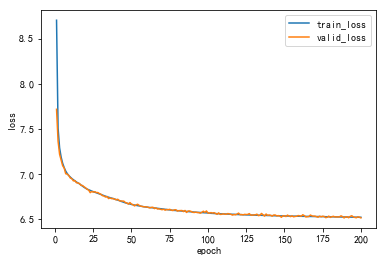

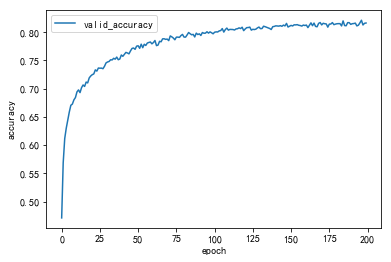

In [64]:
# 隨著 epoch 次數不同，loss 之變化
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1, epoch_size+1, 1), train_loss_list, label='train_loss')
plt.plot(range(1, epoch_size+1, 1), val_loss_list, label='valid_loss')
plt.legend()
plt.show()

# 隨著 epoch 次數不同，accuracy 之變化
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(accuracy_list, label='valid_accuracy' )
plt.legend()
plt.show()

## 使用測試集評估最終結果，accuracy 0.8171

In [66]:
# 預測測試集
predicted = model.predict(ctest_x).reshape(ctest_x.shape[0], 4, 13)
# 將預測結果(one-hot編碼)轉回一般數值
labels = []
ans = []
for i in range(0, len(ctest_y)):
  labels.append(ctable.decode(test_y[i]))
  ans.append(ctable.decode(predicted[i]))

# 計算正確率
acc = accuracy_score(ans, labels)
print('accuracy: ', acc)

accuracy:  0.8171723907969323


In [53]:
# i = 4
# print('test_x:', ctable.decode(test_x[i]))
# print('test_y:',  ctable.decode(test_y[i]))
# print('predicted:', ctable.decode(predicted[i]))

test_x: 856+694
test_y: 1550
predicted: 1550
